# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [79]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 100

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
# check the feature summary file.
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
# copy the dataframes
azdias2 = azdias.copy()

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# remove "[]" from missing_or_unknown string and also put it in the authentic list
feat_str_lists = feat_info["missing_or_unknown"].str[1:-1].str.split(",")

# for loop to convert missing values specified into NaN in each attribute
for attr, miss in zip(feat_info.attribute, feat_str_lists):
    
    # for loop through the list of each attribute
    for element in miss:
        
        # if the element list is not empty
        if len(element) > 0:
            
            # convert the specified value into NaN
            try:
                azdias2[attr] = azdias2[attr].replace(int(element), np.nan)
                
            # the case when the specified value cannot be interpreted as integer
            except:
                print(attr, element)

CAMEO_DEUG_2015 X
CAMEO_DEU_2015 XX
CAMEO_INTL_2015 XX


In [8]:
# convert the nan-meant values(str) into NaN
azdias2["CAMEO_DEUG_2015"] = azdias2["CAMEO_DEUG_2015"].replace("X", np.nan)
azdias2["CAMEO_DEU_2015"] = azdias2["CAMEO_DEU_2015"].replace("XX", np.nan)
azdias2["CAMEO_INTL_2015"] = azdias2["CAMEO_INTL_2015"].replace("XX", np.nan)

In [9]:
# check values of each columns of these 3
azdias2["CAMEO_DEUG_2015"].value_counts(), azdias2["CAMEO_DEU_2015"].value_counts(), azdias2["CAMEO_INTL_2015"].value_counts()

(8    134441
 9    108177
 6    105874
 4    103912
 3     86779
 2     83231
 7     77933
 5     55310
 1     36212
 Name: CAMEO_DEUG_2015, dtype: int64, 6B    56672
 8A    52438
 4C    47819
 2D    35074
 3C    34769
 7A    34399
 3D    34307
 8B    33434
 4A    33155
 8C    30993
 9D    28593
 9B    27676
 9C    24987
 7B    24503
 9A    20542
 2C    19422
 8D    17576
 6E    16107
 2B    15486
 5D    14943
 6C    14820
 2A    13249
 5A    12214
 1D    11909
 1A    10850
 3A    10543
 5B    10354
 5C     9935
 7C     9065
 4B     9047
 4D     8570
 3B     7160
 6A     6810
 9E     6379
 6D     6073
 6F     5392
 7D     5333
 4E     5321
 1E     5065
 7E     4633
 1C     4317
 5F     4283
 1B     4071
 5E     3581
 Name: CAMEO_DEU_2015, dtype: int64, 51    133694
 41     92336
 24     91158
 14     62884
 43     56672
 54     45391
 25     39628
 22     33155
 23     26750
 13     26336
 45     26132
 55     23955
 52     20542
 31     19024
 34     18524
 15     16974
 44     14820


In [10]:
# convert the type of columns"CAMEO_DEUG_2015"and "CAMEO_INTL_2015" into float ("CAMEO_DEU_2015" cannot be)
azdias2["CAMEO_DEUG_2015"] = azdias2["CAMEO_DEUG_2015"].astype(float)
azdias2["CAMEO_INTL_2015"] = azdias2["CAMEO_INTL_2015"].astype(float)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# copy the dataframe
azdias3 = azdias2.copy()

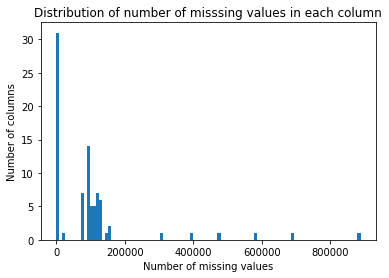

In [18]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# Investigate patterns in the amount of missing data in each column.

plt.hist(azdias3.isnull().sum(), bins=100)
plt.title("Distribution of number of misssing values in each column")
plt.xlabel("Number of missing values")
plt.ylabel("Number of columns");

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

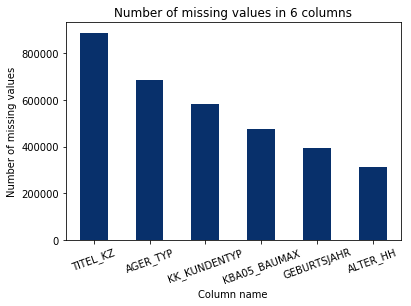

In [19]:
# Investigate the outliers(the columns which have extremely a lot of missing values over 200000)

missed_columns = azdias3.columns[azdias3.isnull().sum() > 200000]
print(missed_columns)
azdias3[missed_columns].isnull().sum().sort_values(ascending=False).plot(kind="bar", colormap="Blues_r")
plt.title("Number of missing values in 6 columns")
plt.xlabel("Column name")
plt.ylabel("Number of missing values")
plt.xticks(rotation=20)

In [23]:
# investigate the number of missing values in other columns
azdias3.isnull().sum()[azdias3.isnull().sum() <= 200000].sort_values()

ZABEOTYP                      0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
GREEN_AVANTGARDE              0
SEMIO_PFLICHT                 0
FINANZTYP                     0
FINANZ_HAUSBAUER              0
FINANZ_UNAUFFAELLIGER         0
FINANZ_ANLEGER                0
FINANZ_VORSORGER              0
FINANZ_SPARER                 0
FINANZ_MINIMALIST             0
SEMIO_TRADV                   0
ANREDE_KZ                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
ALTERSKATEGORIE_GROB       2881
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
GFK_URLAUBERTYP            4854
CJT_GESAMTTYP              4854
HH_EINKO

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias3 = azdias3.drop(columns=missed_columns)
azdias3.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

I removed these 6 columns which had extremely many outliers. Some of them are significantly related to personal information and that may be the reason. About 


#### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

#### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

#### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

#### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

#### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

#### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# copy the dataframe
azdias4 = azdias3.copy()

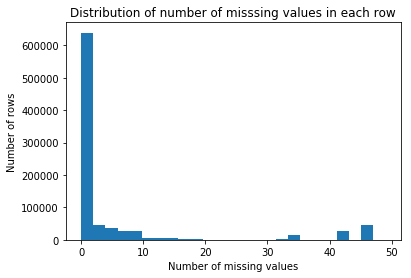

In [27]:
# How much data is missing in each row of the dataset?

missing_of_rows = azdias4.isnull().sum(axis="columns")
plt.hist(missing_of_rows, bins=25)
plt.title("Distribution of number of misssing values in each row")
plt.xlabel("Number of missing values")
plt.ylabel("Number of rows");

In [28]:
# divide the data into two subsets based on the number of missing
# values in each row.

az_many_missing = azdias4[missing_of_rows > 25]
az_little_missing = azdias4[missing_of_rows < 25]

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# function to compare the distribution of specific feature
# between people with missing values and people without them
def compare_distr(column):
    az_many_missing["missing values in a row"] = "many"
    az_little_missing["missing values in a row"] = "few"
    df_for_bar = pd.concat([az_many_missing, az_little_missing])
    
    sns.countplot(x=column, hue="missing values in a row", data=df_for_bar)
    plt.title(column, fontsize=40)
    plt.xlabel("Category", fontsize=40)
    plt.ylabel("Number of rows", fontsize=40);

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


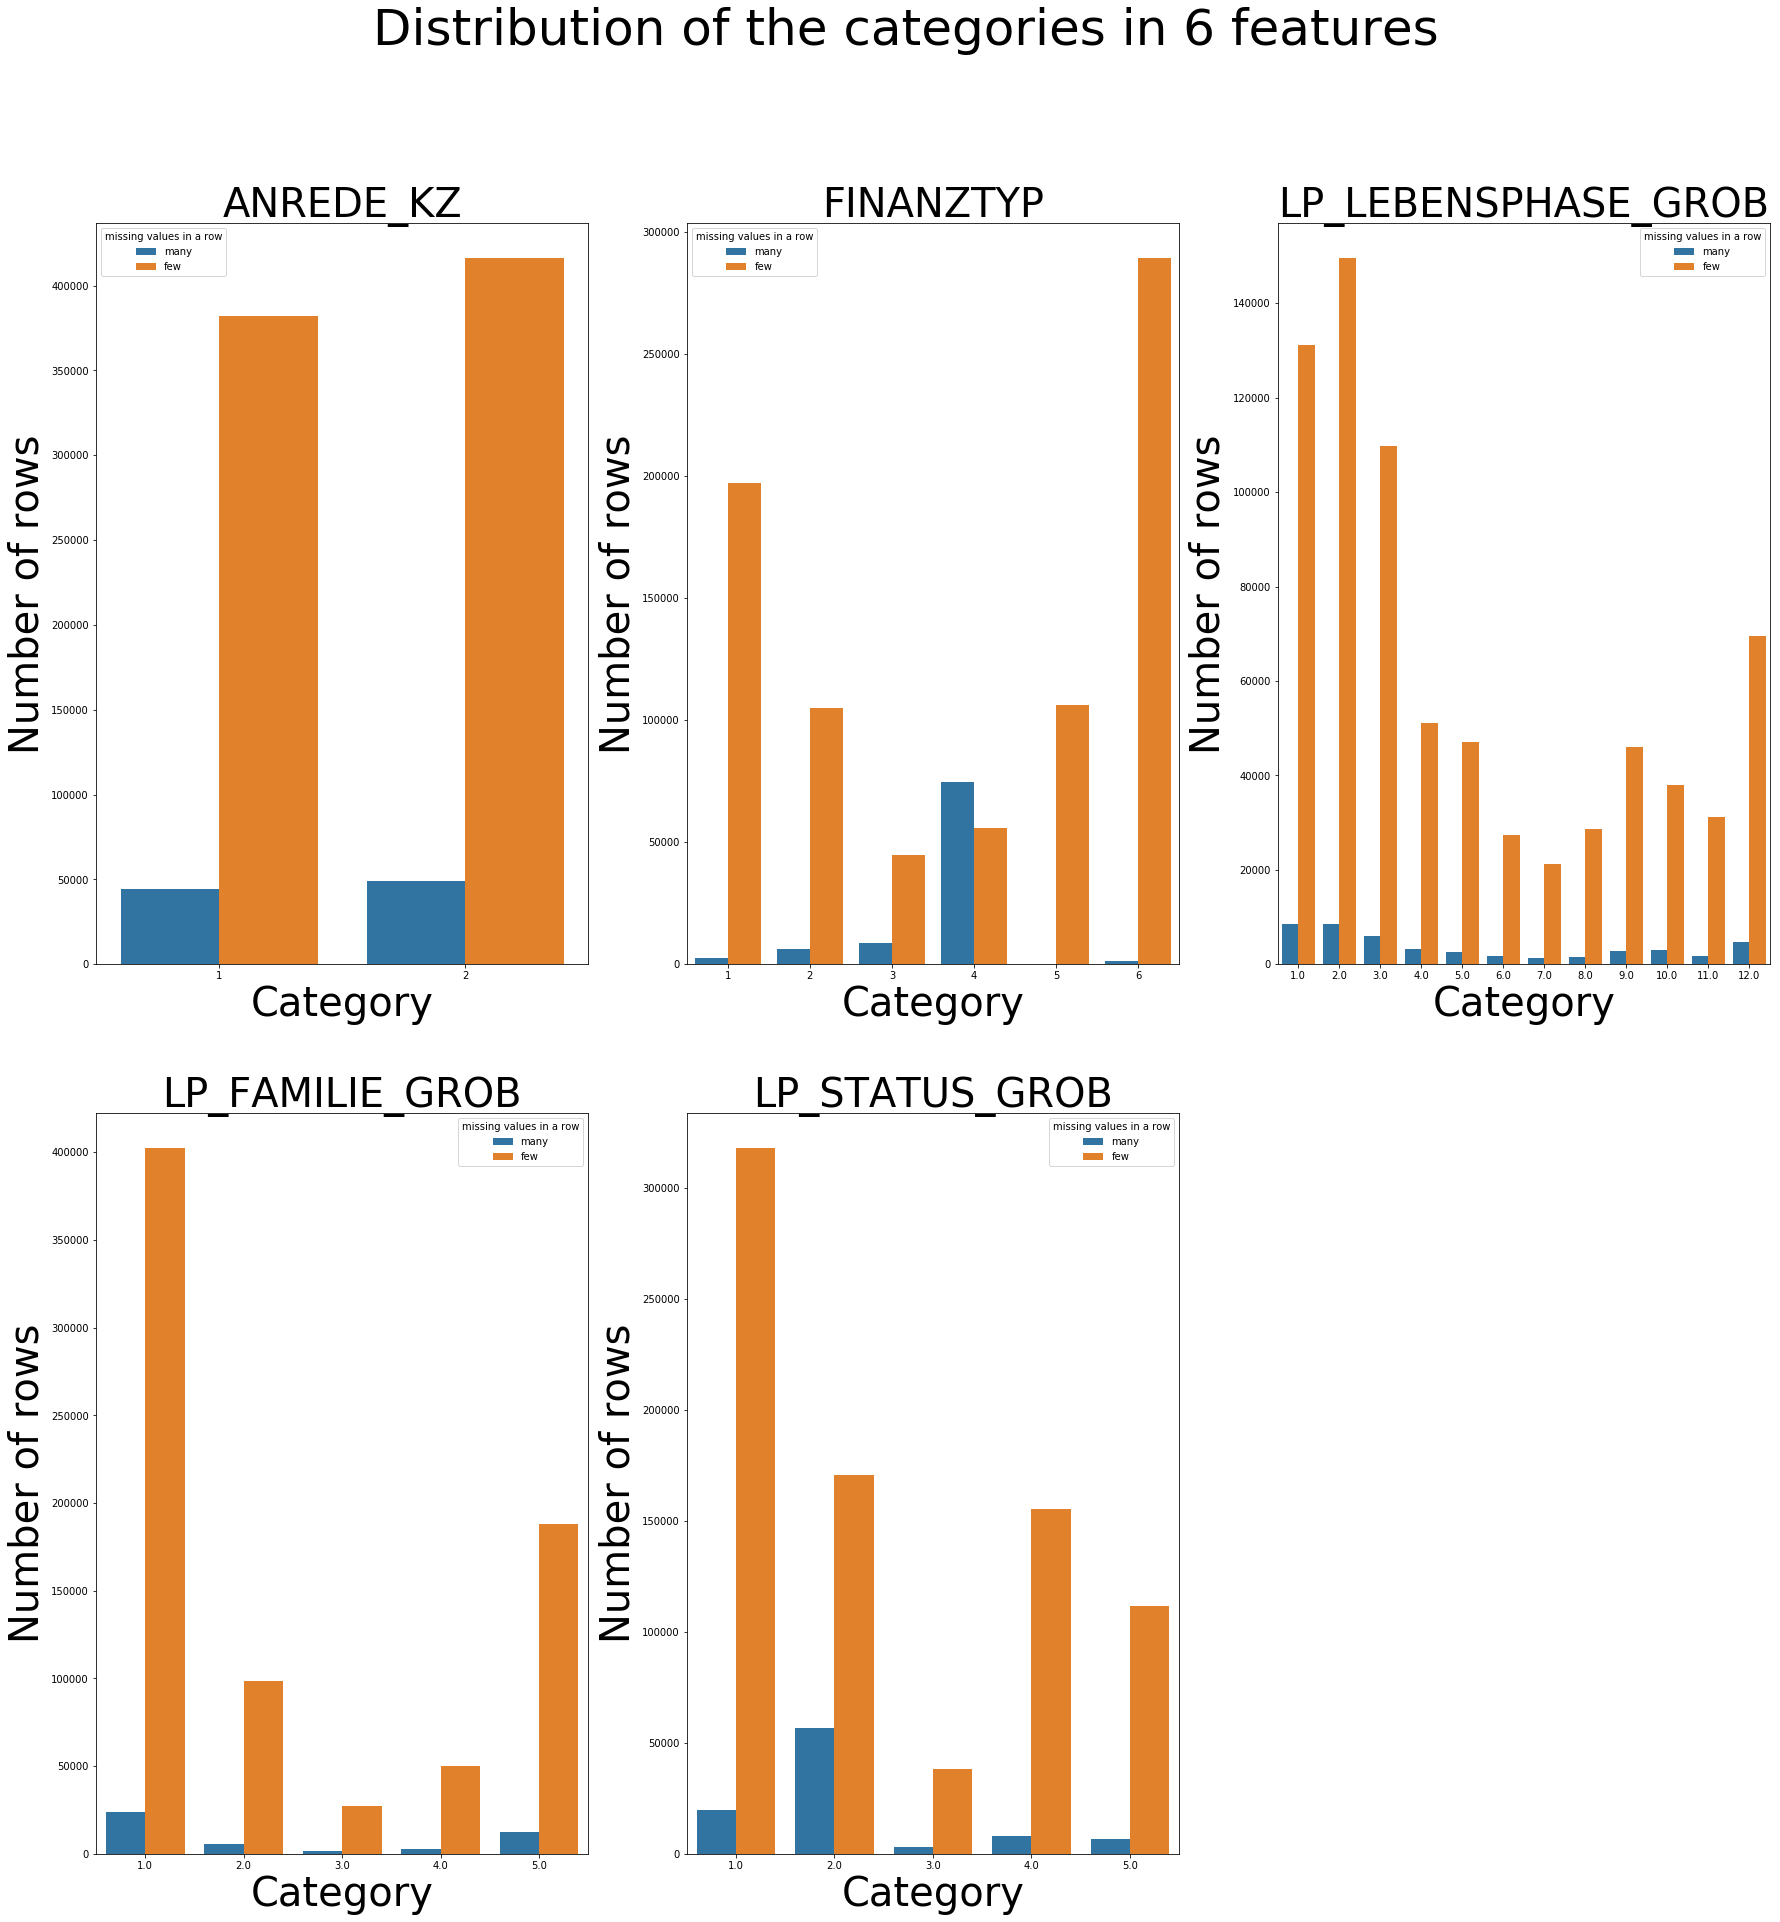

In [30]:
# plot 5 distributions and compare
fig = plt.figure(figsize=[30,30])

plt.subplot(2,3,1)
compare_distr("ANREDE_KZ")
plt.subplot(2,3,2)
compare_distr("FINANZTYP")
plt.subplot(2,3,3)
compare_distr("LP_LEBENSPHASE_GROB")
plt.subplot(2,3,4)
compare_distr("LP_FAMILIE_GROB")
plt.subplot(2,3,5)
compare_distr("LP_STATUS_GROB")

plt.suptitle("Distribution of the categories in 6 features", fontsize=50);

In [31]:
# extract the rows without so many missing values in them
azdias4 = azdias4[missing_of_rows < 25]

#### Discussion 1.1.3: Assess Missing Data in Each Row

I compared [people with many missing values about them] and [people without so many or any missing values about them] to check the bias between them. I focused on the 5 features including "ANREDE_KZ", "FINANZTYP", "LP_LEBENSPHASE_GROB", "LP_FAMILIE_GROB", and "LP_STATUS_GROB". There could not been found significant differences on most of them aside "LP_FAMILIE_GROB"(see below). It tells that people whose family type is "single parent" tend to have many more missing values on their data. I could not find the exact reason, but it may have to be kept in mind. 

**So many missing values for people whose FINANZTYP = 3**


#### 1.14. LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# copy the dataframe
azdias5 = azdias4.copy()

In [33]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
multi_category = []

# features which are categorical
cat_features = feat_info[feat_info.type == "categorical"]

# loop thorough each categorical features
for attr in cat_features.attribute:
    try:
        
        # if the categorical fetures is binary (2 categories)
        if azdias5.loc[:,attr].nunique() == 2:
            print("binary with {} values              ".format(azdias5.loc[:,attr].dtype), attr)
                
        # if the categorical fetures is multi-level (more than 2 categories)
        elif azdias5.loc[:,attr].nunique() > 2:
            multi_category.append(attr)
        else:
            print("Categorical Something Wrong!")
    except:
        print("Not in columns any more               ", attr)

Not in columns any more                AGER_TYP
binary with int64 values               ANREDE_KZ
binary with int64 values               GREEN_AVANTGARDE
binary with float64 values               SOHO_KZ
Not in columns any more                TITEL_KZ
binary with float64 values               VERS_TYP
Not in columns any more                KK_KUNDENTYP
binary with object values               OST_WEST_KZ


In [35]:
# check the multiple category features
multi_category

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [36]:
# check the binary features whose values are not numeric
azdias5["OST_WEST_KZ"].value_counts()

W    629388
O    168518
Name: OST_WEST_KZ, dtype: int64

In [37]:
# Re-encode categorical variable "OST_WEST_KZ" to numeric values
azdias5["OST_WEST_KZ"] = azdias5["OST_WEST_KZ"].replace({"O":0, "W":1}).astype(float)
azdias5.rename(columns={"OST_WEST_KZ": "OST_WEST_KZ(W=1)"}, inplace=True)

In [38]:
# make one-hot encoding features from multiple level category columns
## !!!! I have to take care that NaN column would be created

# loop thorough multi-level category features
for category in multi_category:
    try:
        # make dummy features from each feature
        dummy = pd.get_dummies(azdias5[category].astype(str), prefix=category)
        # join the dummy features to the original dataframe
        azdias5 = azdias5.join(dummy)
        # remove the original multi-level category feature
        azdias5.drop(columns=category, inplace=True)
    
    except Exception as e:
        print(category, azdias5[category].dtype,e)

In [39]:
#check the columns which is made by nan values
nan_columns = azdias5.columns[azdias5.columns.str.contains("_nan|_X|_XX")]
nan_columns

Index(['CJT_GESAMTTYP_nan', 'GFK_URLAUBERTYP_nan', 'LP_FAMILIE_FEIN_nan',
       'LP_FAMILIE_GROB_nan', 'LP_STATUS_FEIN_nan', 'LP_STATUS_GROB_nan',
       'NATIONALITAET_KZ_nan', 'SHOPPER_TYP_nan', 'CAMEO_DEUG_2015_nan',
       'CAMEO_DEU_2015_nan'],
      dtype='object')

In [40]:
# remove nan-columns
azdias5.drop(columns=nan_columns,inplace=True)
azdias5.head(0)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ(W=1),WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E


#### Discussion 1.2.1: Re-Encode Categorical Features

- For binary categoricals　with numeric values, I kept them without needing to do anything.  
- For binary categoricals　with non-numeric values('OST_WEST_KZ'), I replaced them with 0 and 1.  
- For multi-level categoricals (below), I used multiple dummy variables (and dropped original variable later).


#### multi categorical variable :   
['CJT_GESAMTTYP'
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
# copy the dataframe
azdias6 = azdias5.copy()

In [65]:
# Investigate "PRAEGENDE_JUGENDJAHRE" 
azdias6["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    182964
8.0     141598
10.0     85793
5.0      84682
3.0      53840
15.0     42540
11.0     35746
9.0      33569
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [66]:
## engineer two new variables from feature "PRAEGENDE_JUGENDJAHRE"

dict_interval = {}
dict_main = {}

# make a dictionary for 1st feature (interval)
for i in range(1,16):
    if i in [1,2]:
        dict_interval[i] = 40
    elif i in [3,4]:
        dict_interval[i] = 50
    elif i in [5,6,7]:
        dict_interval[i] = 60
    elif i in [8,9]:
        dict_interval[i] = 70
    elif i in [10,11,12,13]:
        dict_interval[i] = 80
    elif i in [14,15]:
        dict_interval[i] = 90

# make a dictionar for 2nd feature (mainstream movement)
for i in range(1,16):
    if i in [1,3,5,8,10,12,14]:
        dict_main[i] = 1
    elif i in [2,4,6,7,9,11,13,15]:
        dict_main[i] = 0

# add these 2 new columns    
azdias6["interval_type"] = azdias6["PRAEGENDE_JUGENDJAHRE"].replace(dict_interval)
azdias6["mainstream"] = azdias6["PRAEGENDE_JUGENDJAHRE"].replace(dict_main)    

# remove original column
azdias6 = azdias6.drop(columns="PRAEGENDE_JUGENDJAHRE")

In [67]:
# check new 2 features
azdias6[["interval_type","mainstream"]].describe()

,interval_type,mainstream
count,769209.000000,769209.000000
mean,73.319761,0.772223
std,14.574449,0.419398
min,40.000000,0.000000
25%,60.000000,1.000000
50%,70.000000,1.000000
75%,90.000000,1.000000
max,90.000000,1.000000


In [68]:
# Investigate "CAMEO_INTL_2015" to engineer two new variables.
azdias6["CAMEO_INTL_2015"].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       nan, 25., 23., 31., 52., 35., 45., 44., 32.])

In [69]:
## engineer two new variables from feature "CAMEO_INTL_2015"
azdias6["house_wealth"] = azdias6["CAMEO_INTL_2015"].astype(str).str[0]
azdias6["family_typol"] = azdias6["CAMEO_INTL_2015"].astype(str).str[1]

# check newly made new features' values
print(azdias6["house_wealth"].value_counts())
print(azdias6["family_typol"].value_counts())

# remove the original feature 
azdias6.drop(columns="CAMEO_INTL_2015", inplace=True)

5    223577
2    190652
4    189959
1    119431
3     68181
n      6106
Name: house_wealth, dtype: int64
1    245039
4    232761
3    119670
5    117040
2     77290
a      6106
Name: family_typol, dtype: int64


In [70]:
#replace n & a(from nan) to NaN, and also convert them back to float
azdias6["house_wealth"] = azdias6["house_wealth"].replace("n", np.nan).astype(float)
azdias6["family_typol"] = azdias6["family_typol"].replace("a", np.nan).astype(float)

# check new 2 features
azdias6[["house_wealth", "family_typol"]].describe()

,house_wealth,family_typol
count,791800.000000,791800.000000
mean,3.262186,2.873040
std,1.464498,1.484791
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,3.000000
75%,5.000000,4.000000
max,5.000000,5.000000


In [71]:
#  other mixed features aside from these 2

mixed_features = feat_info[feat_info.type == "mixed"].attribute
other_mixed = mixed_features[ (mixed_features != "PRAEGENDE_JUGENDJAHRE") & (mixed_features != "CAMEO_INTL_2015") ]

# remove the columns which were already deleted in step1.1.2
other_mixed = [col for col in other_mixed if col not in missed_columns] 
print(other_mixed)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']


In [72]:
# remove these 5 features if they are not deleted before
azdias6.drop(columns=features_toberemoved, inplace=True, errors="ignore")

#### Discussion 1.2.2: Engineer Mixed-Type Features

I made 2 new features each out of specified 2 mixed features. In detail, I made 2 columns("interval_type","mainstream") from a mixed column "PRAEGENDE_JUGENDJAHRE" as well as "house_wealth" and "family_typol" features from column "CAMEO_INTL_2015".  
  
I deleted other 4 mixed columns(below) from the data in this project. This is because their features can be explained by the combination of other features which already exist. For example of LP_LEBENSPHASE_FEIN, it can be explained as the combination of "LP_FAMILIE_FEIN"(Family type) + "FINANZ" features + "ALTERSKATEGORIE_GROB"(age).
   
   
* LP_LEBENSPHASE_FEIN [Life stage, fine scale] 
* LP_LEBENSPHASE_GROB [Life stage, rough scale]
* WOHNLAGE [Neighborhood quality (or rural flag)]
* PLZ8_BAUMAX [Most common building type within the PLZ8 region]

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# copy the dataframe
azdias7 = azdias6.copy()

In [74]:
# convert all cells into float (This makes it sure that there are neither string columns nor NaN in int columns)
azdias7 = azdias7.astype(float)

In [75]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias7.shape

(797906, 192)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
# clean the dataframe as the same way as the demographic dataframe was done
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    #for loop for "featurename * [a,b,c]" of nan-meant infomation dataframe 
    for attr, miss in zip(feat_info.attribute, feat_str_lists):

        #  for loop through the list of each attribute
        for element in miss:

            # if the element list is not empty
            if len(element) > 0:
                try:
                    df[attr] = df[attr].replace(int(element), np.nan)

                # the case when the element cannot be interpreted as integer
                except:
                    try:
                        df[attr] = df[attr].replace("X", np.nan).replace("XX", np.nan).astype(float)
                    #the case when the element cannot be ininterpreted as str nor int
                    except Exception as e:
                        
                        # "CAMEO_DEU_2015" is a multiple categorical feature, and would be 1-hot encoded later. So its ok now.
                        assert attr == "CAMEO_DEU_2015"
                    
    
    # remove  columns and rows with many missing values
    df = df.drop(columns=missed_columns)
    missing_of_rows = df.isnull().sum(axis="columns")
    df = df[missing_of_rows < 25]
    
    # select, re-encode, and engineer column values.
    ### For the column "OST_WEST_KZ" (that takes on non-numeric values), re-encode the values as numbers
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"O":0, "W":1}).astype(float)
    df.rename(columns={"OST_WEST_KZ": "OST_WEST_KZ(W=1)"}, inplace=True)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    # make dummy dataframes from multiple level category columns
    ## I have to take care that nan would also be converted into string and the dummy column of them would be created
    for category in multi_category:
        try:
            dummy = pd.get_dummies(df[category].astype(str), prefix=category)
            df = df.join(dummy)
            df.drop(columns=category, inplace=True)
        except Exception as e:
            print("2",category, df[category].dtype,e)
        
    # remove nan-columns from one-hot encoding features
    nan_columns = df.columns[df.columns.str.contains("_nan|_X|_XX")]
    df.drop(columns=nan_columns,inplace=True)
        
    # meke 2 ordinal columns form mixed feature "PRAEGENDE_JUGENDJAHRE"
    df["interval_type"] = df["PRAEGENDE_JUGENDJAHRE"].replace(dict_interval)
    df["mainstream"] = df["PRAEGENDE_JUGENDJAHRE"].replace(dict_main)    
    df.drop(columns="PRAEGENDE_JUGENDJAHRE", inplace=True)

    # meke 2 ordinal columns form mixed feature "CAMEO_INTL_2015"
    df["house_wealth"] = df["CAMEO_INTL_2015"].astype(str).str[0]
    df["family_typol"] = df["CAMEO_INTL_2015"].astype(str).str[1]
    df.drop(columns="CAMEO_INTL_2015", inplace=True)
    
    #replace n & a(from nan) to NaN in "these newly made 2 features, and also convert them back into float
    df["house_wealth"] = df["house_wealth"].replace("n", np.nan).astype(float)
    df["family_typol"] = df["family_typol"].replace("a", np.nan).astype(float)
    
    # remove these 5 features if they were not deleted before
    df.drop(columns=features_toberemoved, inplace=True, errors="ignore")

    # convert all cells into float
    df = df.astype(float)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [77]:
# copy the dataframe
az = azdias7.copy()

In [78]:
# consider the process of removing all columns or rows which include NaN in them
print(az.shape)
print("{} if I remove all columns including NaN".format(az.dropna(axis="columns").shape))
print("{} if I remove all rows including NaN".format(az.dropna(axis="rows").shape))

(797906, 192)
(797906, 157) if I remove all columns including NaN
(623211, 192) if I remove all rows including NaN


In [187]:
## I decided not to remove them.
## Instead, I will fill them with the mean of values in the same column

#get the filled numpy array
imputer = Imputer()
az2 = pd.DataFrame(imputer.fit_transform(az))

#set the column names
az2.columns = az.columns

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [190]:
# Apply feature scaling to the general population demographics data.

# instantiate standardizing object
#### THIS WOULD BE REUSED BETTER FOR CUSTOMER DATASET
scaler = RobustScaler()

# fit it and also get the standardized numpy array
az3 = pd.DataFrame(scaler.fit_transform(az2))

#set the column names
az3.columns = az.columns

In [191]:
#check mean = 0 and std = 1
az3.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ(W=1),KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,interval_type,mainstream,house_wealth,family_typol
count,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,7.979060e+05,797906.000000,797906.000000,797906.000000,7.979060e+05,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.00000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,7.979060e+05,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,797906.000000,79790

### Discussion 2.1: Apply Feature Scaling

Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.

Based on the reference below, I decided not to remove rows because if I do it, the rows of data would be approximately 600000 even though it was about 900000 in the original data. This is more than 30% and that can make the clustering less effective. Instead, I will fill the NaN values with the mean of that row. This would be work better because I have already removed the rows which has extremely many missing values in columns in step 1.1. 

**reference :**
[5 Ways To Handle Missing Values In Machine Learning Datasets](https://www.analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/)  
  
1. Deleting Rows 
 * Pros: Complete removal of data with missing values results in robust and highly accurate model
 * Cons: Works poorly if the percentage of missing values is high (say 30%), compared to the whole dataset
 
2. Replacing With Mean/Median/Mode (for numeric variables)
 * Pros: This is a better approach when the data size is small
 * Cons: Imputing the approximations add variance and bias
 
3. Assigning An Unique Category (for categorical variables)
 * Pros: Less possibilities with one extra category, resulting in low variance after one hot encoding - since it is categorical
 * Cons: Negates the loss of data by adding an unique category
 
4. Predicting The Missing Values (e.g. linear regression)
 * Pros: Imputing the missing variable is an improvement as long as the bias from the same is smaller than the omitted variable bias
 * Cons: Bias also arises when an incomplete conditioning set is used for a categorical variable
 
5. Using Algorithms Which Support Missing Values (e.g.k-means)
 * Pros: Does not require creation of a predictive model for each attribute with missing data in the dataset
 * Cons: Is a very time consuming process and it can be critical in data mining where large databases are being extracted


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [192]:
# copy the dataframe
az4 = az3.copy()

In [193]:
### Find the primal components from these 192 features

# instanciate the PCA object
##### THIS WOULD BE REUSED LATER AGAIN
pca = PCA()

# fit this object and also get the transformed dataframe (coordinates of each data  points in new pc space)
X_pca = pca.fit_transform(az4)

In [194]:
# Investigate the variance accounted for by each principal component.

cumulative_per = 0

for i, per in enumerate(pca.explained_variance_ratio_):
    cumulative_per += per
    print("{}th explains {}% of variance - now cumulatively {}%".format(i+1, round(per*100,3), round(cumulative_per*100, 1) ) )

1th explains 20.13% of variance - now cumulatively 20.1%
2th explains 13.357% of variance - now cumulatively 33.5%
3th explains 7.203% of variance - now cumulatively 40.7%
4th explains 6.111% of variance - now cumulatively 46.8%
5th explains 5.563% of variance - now cumulatively 52.4%
6th explains 5.062% of variance - now cumulatively 57.4%
7th explains 3.586% of variance - now cumulatively 61.0%
8th explains 3.398% of variance - now cumulatively 64.4%
9th explains 2.578% of variance - now cumulatively 67.0%
10th explains 1.965% of variance - now cumulatively 69.0%
11th explains 1.605% of variance - now cumulatively 70.6%
12th explains 1.433% of variance - now cumulatively 72.0%
13th explains 1.232% of variance - now cumulatively 73.2%
14th explains 1.177% of variance - now cumulatively 74.4%
15th explains 1.047% of variance - now cumulatively 75.4%
16th explains 1.012% of variance - now cumulatively 76.5%
17th explains 0.941% of variance - now cumulatively 77.4%
18th explains 0.783% o

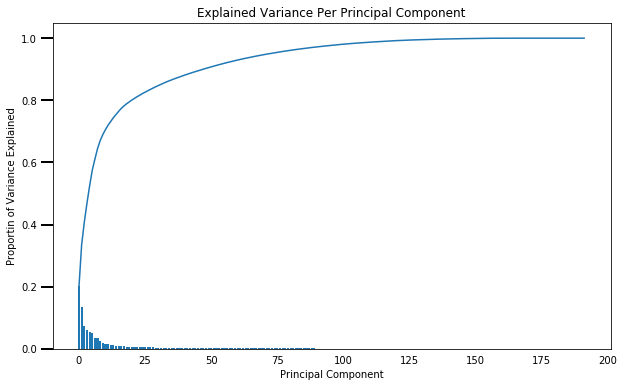

In [195]:
#visualize Explained Variance Per Principal Component
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Proportin of Variance Explained")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

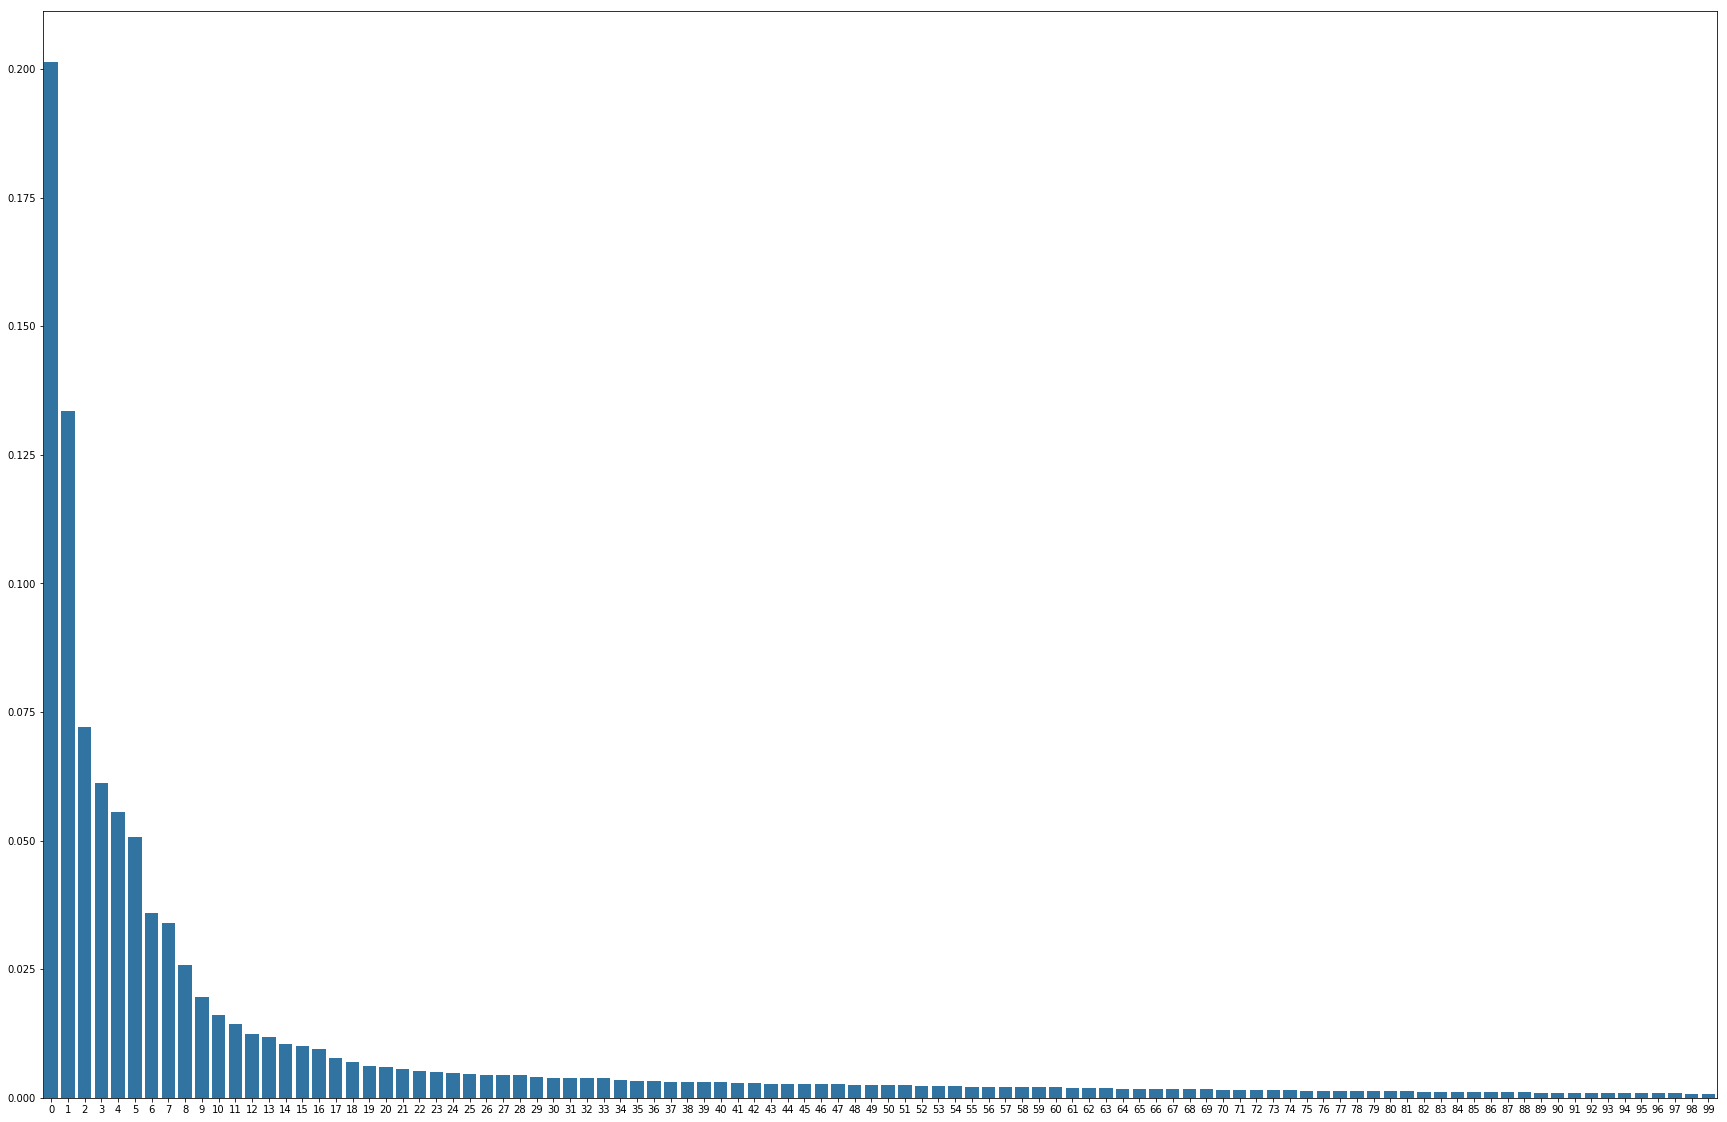

In [199]:
#visualize Explained Variance of top100 Principal Component

plt.figure(figsize=[30,20])
sns.barplot(x=np.arange(100), y=pca.explained_variance_ratio_[:100], color=sns.color_palette()[0]);

In [197]:
# I decided to set the threshold at the number of components which explains more than 80% in total
# (The reason would be written in discussion part below)
# So in this project, I will use 66 components
# Re-apply PCA to the data while selecting for number of components to retain.

pca66 = PCA(66)
X_pca66 = pca66.fit_transform(az4)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to use 66 principal components to explain more than 70% of variance.  
  
I decided this threshold(70%) by looking at the graph of percentage of variance explained by each primal components. I took care of 2 aspects for this decision. 

1. From the last graph, I can find that there is a "elbow" at around 10th primal component. However, these first 10 components explains less than 20% of the total variance, so these are not enough. 

2. The graph shows that the graph of these variances has a very long tail on its left and thus, setting too high threshold means that it would get computationally so expensive.  
  
Based on these 2 factors, I concluded that the total variance explained by principal components should be 70%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [183]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# print the features which has 5highest/5lowest weights on  i-th principal component 
def component_weights(pca, i):
    weights = pd.DataFrame(np
                           .reshape(pca.components_[i-1],(1, -1)))
    weights.columns = az4.columns

    weights = weights.sort_values(by=0, ascending=False, axis=1)
    print(weights.iloc[0,:5], "\n")
    print(weights.iloc[0,-5:])
    #for col,w in zip(weights.columns, weights.iloc[0]):
       # print(col,w)

In [184]:
# print the features which has 5highest/5lowest weights on 1st principal component 
component_weights(pca66,1)

LP_STATUS_GROB_1.0    0.196749
HH_EINKOMMEN_SCORE    0.186853
house_wealth          0.186744
PLZ8_ANTG3            0.182545
PLZ8_ANTG4            0.176668
Name: 0, dtype: float64 

KBA05_GBZ           -0.182285
PLZ8_ANTG1          -0.183223
FINANZ_MINIMALIST   -0.192178
KBA05_ANTG1         -0.192289
MOBI_REGIO          -0.205260
Name: 0, dtype: float64


In [185]:
# print the features which has 5highest/5lowest weights on 2nd principal component 
component_weights(pca66,2)

ALTERSKATEGORIE_GROB    0.233030
FINANZ_VORSORGER        0.219055
ZABEOTYP_3              0.200224
SEMIO_ERL               0.180052
SEMIO_LUST              0.163718
Name: 0, dtype: float64 

SEMIO_TRADV             -0.208043
SEMIO_REL               -0.213916
FINANZ_UNAUFFAELLIGER   -0.215526
FINANZ_SPARER           -0.226739
interval_type           -0.237896
Name: 0, dtype: float64


In [186]:
# print the features which has 5highest/5lowest weights on 3rd principal component 
component_weights(pca66,3)

SEMIO_VERT     0.319115
SEMIO_FAM      0.260998
SEMIO_SOZ      0.257280
SEMIO_KULT     0.252077
FINANZTYP_5    0.134622
Name: 0, dtype: float64 

SEMIO_ERL    -0.208401
SEMIO_KRIT   -0.267306
SEMIO_DOM    -0.284330
SEMIO_KAEM   -0.315728
ANREDE_KZ    -0.345530
Name: 0, dtype: float64


### Discussion 2.3: Interpret Principal Components

### 1st principal component
* **LP_STATUS_GROB_1.0** >> Social status: (11: single low-income and average earners of younger age)  
* **HH_EINKOMMEN_SCORE** >> Estimated household net income: (6=very low income)  
* **house_wealth**      >> Poorer Households: (6=very low income) [from"PRAEGENDE_JUGENDJAHRE"]  
-----   
* **FINANZ_MINIMALIST** >> financial typology - MINIMALIST: low financial interest (5: very low)   
* **KBA05_ANTG1** >> Number of 1-2 family houses in the microcell (4: very high share of 1-2 family homes)   
* **MOBI_REGIO** >> Movement patterns (5: very low movement)   

**This 1st principal component suggests the direction where the person tend to be younger and single and lower-income.**  

### 2nd principal component   
   
* **ALTERSKATEGORIE_GROB** >> Estimated age based on given name analysis (4: > 60 years old)  
* **FINANZ_VORSORGER**     >> Financial typology - VORSORGER: be prepared (5 = very low)  
* **ZABEOTYP_3**           >> Energy consumption typology (3= fair supplied)   
-----
* **SEMIO_REL**            >> ersonality typology of religious (6= lowest affinity)  
* **FINANZ_SPARER**        >> Financial typology - SPARER: money-saver (5=very low)  
* **interval_type**        >> person's youth era (90=90s) [from"PRAEGENDE_JUGENDJAHRE"]  

**This 2nd principal component suggests the direction where the person tend to be older, modest in consumption, religious.**
  
### 3rd principal component:
* **SEMIO_VERT**  >>  Personality typology, VERT: dreamful (7: lowest affinity)  
* **SEMIO_FAM** >>  FAM: family-minded  
* **SEMIO_SOZ**   >>  SOZ: socially-minded  
* **SEMIO_KULT** >>   KULT: cultural-minded   
-----
* **SEMIO_ERL**  >>  ERL: event-oriented  
* **SEMIO_KRIT**  >>  KRIT: critical-minded  
* **SEMIO_DOM**  >>  DOM: dominant-minded  
* **SEMIO_KAEM**  >>  KAEM: combative attitude    
* **ANREDE_KZ**  >>  Gender (1:male, 2:female)  

**This 3rd principal component suggests the direction where the person tend to be aggressive, that is, less family/socially/cultural-minded and instead, critical/dominant/combative. Also, it is suggested that this tendency is found for male rather than female.**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [108]:
# Over a number of different cluster counts...

scores = []

for k in range(1,11):  #########test!!!!!!!!

    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    kmeans.fit(X_pca66)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(X_pca66)) 
    scores.append(score)  
    
    print("currently checked {} clusters' case. The score: {}".format(k,score))

currently checked 1 clusters' case. The score: 44492488.92885143
currently checked 2 clusters' case. The score: 37603421.75249138
currently checked 3 clusters' case. The score: 33085507.427785497
currently checked 4 clusters' case. The score: 30738438.61448053
currently checked 5 clusters' case. The score: 28914285.943600144
currently checked 6 clusters' case. The score: 27261904.671062883
currently checked 7 clusters' case. The score: 26396685.656168677
currently checked 8 clusters' case. The score: 25583470.835449994
currently checked 9 clusters' case. The score: 24878380.41138431
currently checked 10 clusters' case. The score: 24360450.13944661


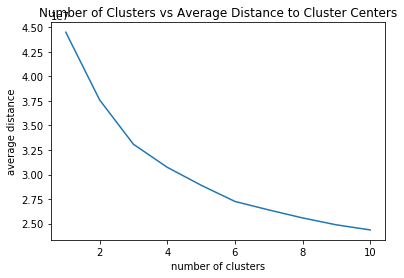

In [109]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(np.arange(1, len(scores)+1, 1), scores, linestyle="-")
plt.title("Number of Clusters vs Average Distance to Cluster Centers")
plt.xlabel("number of clusters")
plt.ylabel("average distance");

In [167]:
### Even though I could not find the clear elbow, I am determined to use 5 for # of clusters.

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# instantiate the kmean object(k=5)
kmeans5= KMeans(5)

# fit the kmeans model with X_pca66 (THIS WOULD BE USED LATER)
# and also get the clustering result labels
demo_clusters = pd.Series(kmeans5.fit_predict(X_pca66))

# count each number of label
demo_clusters.value_counts()

4    303168
0    276307
1    155570
3     49150
2     13711
dtype: int64

### Discussion 3.1: Apply Clustering to General Population

I used to elbow method to determine the number of clusters. I visualized each k (1 to 10)'s score (average distance from each point to a centroid of the cluster where that point belongs to). Unfortunately, I could not find the elbow in the plot, but I decided to set k=5, after which the graph levels off enough.  
   
By applying k-means clustering to the demographic data, I classified each pf people and toggled 1 of 5 labels. Around 100000 to 200000 people belong to each label.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [168]:
# Load in the customer demographics data.
cust = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [169]:
# copy the dataframe
cust2 = cust.copy()

In [150]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# clean the customers dataframe as the same way as the demographic dataframe was done
cust2 = clean_data(cust2)

In [151]:
print("shape of customers' data after cleaning :",az4.shape)
print("shape of demographic data after cleaning :",cust2.shape)

shape of customers' data after cleaning : (797906, 192)
shape of demographic data after cleaning : (141701, 191)


In [152]:
## It is revealed that customers data has 1 more feature after cleaned.
## I will find this

for demo_feature in az4.columns:
    if demo_feature not in cust2.columns:
        print("{} is not in cleaned customers dataframe features".format(demo_feature))
        
for customer_feature in cust2.columns:
    if customer_feature not in az4.columns:
        print("{} is not in cleaned demographic dataframe feature".format(customer_feature))

GEBAEUDETYP_5.0 is not in cleaned customers dataframe features


In [153]:
## add the feature "GEBAEUDETYP_5.0" in cleaned customers' dataframe
cust2["GEBAEUDETYP_5.0"] = 0.

# re-order the features of dataframe as same as demographic dataframe
cust2 = cust2[az4.columns]

assert (az4.columns == cust2.columns).all()

In [155]:
# fill NaN cells in cust2 using means of each column

# get the filled numpy array
cust3 = pd.DataFrame(Imputer().fit_transform(cust2))

#set the column names
cust3.columns = cust2.columns

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [156]:
# noramalize the dataframe with using the scaler object which was used for scaling cleaned demographic dataframe
cust4 = pd.DataFrame(scaler.transform(cust3))

# set the column names again
cust4.columns = cust3.columns

In [157]:
# check mean is not so far from 0 as well as std not from 1
cust4.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ(W=1),KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,interval_type,mainstream,house_wealth,family_typol
count,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,141701.000000,1

In [158]:
# create 66 principal components
Xcust_pca = pca66.transform(cust4)

In [159]:
# predict customer labels using kmeans model
cust_clusters = pd.Series(kmeans5.predict(Xcust_pca))
cust_clusters.value_counts()

0    67227
3    43184
2    22363
4     7421
1     1506
dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [160]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# count number of each label in the demographic data
demo_counts = demo_clusters.value_counts()

# add another label "removed" for the points of data which were removed through the cleaning process
demo_counts["removed"] = azdias.shape[0] - demo_clusters.count()


# count number of each label in the customers' data
cust_counts = cust_clusters.value_counts()

# add another label "removed" for the points of data which were removed through the cleaning process
cust_counts["removed"] = cust.shape[0] - cust_clusters.count()


# calculate the proportion of each label from the count
demo_prop = demo_counts / demo_counts.sum()
cust_prop = cust_counts / cust_counts.sum()

# set the index to string (to sort the label names by which)
demo_prop.index = demo_prop.index.astype(str)
cust_prop.index = cust_prop.index.astype(str)

# sort the label names
demo_f = demo_prop.sort_index()
cust_f = cust_prop.sort_index()

In [161]:
print(demo_f)
cust_f

0          0.174558
1          0.015380
2          0.340163
3          0.310045
4          0.055149
removed    0.104705
dtype: float64


0          0.350776
1          0.007858
2          0.116685
3          0.225325
4          0.038721
removed    0.260634
dtype: float64

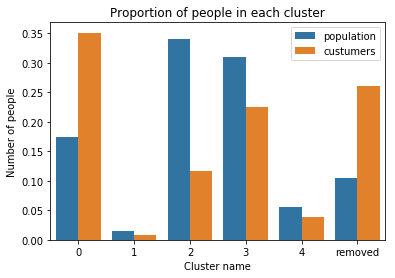

In [162]:
# visualize the result to compare demographic data and customers' data

demo_temp = pd.DataFrame({"label":demo_f.index, "prop":demo_f} )
demo_temp["kind"] = "population"
cust_temp = pd.DataFrame({"label":cust_f.index, "prop":cust_f} )
cust_temp["kind"] = "custumers"
df_temp = pd.concat([demo_temp, cust_temp])

sns.barplot(data=df_temp, x="label", y="prop", hue="kind")

plt.title("Proportion of people in each cluster")
plt.xlabel("Cluster name")
plt.ylabel("Number of people")
plt.legend();

In [163]:
def plot_scaled_comparison(df_origin, kmeans, i):
    
    # get the center of i-th out of5 clusters in the space of 66 principal components
    cent_pc = pd.Series(kmeans5.cluster_centers_[i])
    #convert these i-th centroid back into the space of NORMALIZED192 featues.
    cent_origin = pd.Series(pca66.inverse_transform(cent_pc), index=df_origin.columns)

    # show the significant features in i-th cluster
    X = pd.DataFrame.from_dict(dict(zip(df_origin.columns, cent_origin)), orient='index').rename(
        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh')
    plt.title("Features of {}th cluster's centroid".format(i));

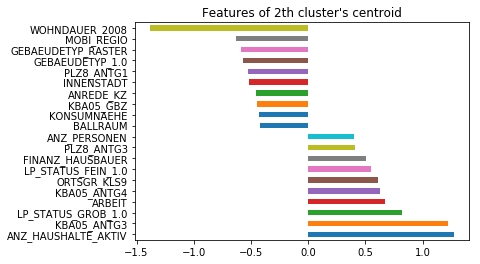

In [164]:
plot_scaled_comparison(az4, kmeans5, 2)

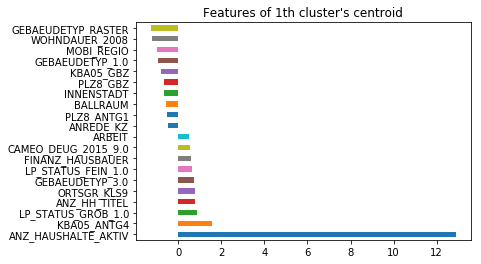

In [166]:
plot_scaled_comparison(az4, kmeans5, 1)

In [98]:
## investigate the attribute of points in cluster "3"
# take a look at the centroid of cluster 3

# get the coordicate of  the centroid of cluster 3
cent2_origin = pd.Series(centroids_origin[3], index=az4.columns)

# plot the coordinate of each original variable
print(cent2_origin.sort_values(ascending=False)[:5], "\n")
print(cent2_origin.sort_values(ascending=False)[-5:])

LP_STATUS_FEIN_10.0    2.017466
LP_STATUS_GROB_5.0     2.017466
GREEN_AVANTGARDE       1.823311
FINANZ_MINIMALIST      1.030937
KBA05_ANTG1            0.942899
dtype: float64 

LP_STATUS_GROB_1.0   -0.767838
FINANZ_HAUSBAUER     -0.774796
house_wealth         -0.850519
HH_EINKOMMEN_SCORE   -1.327282
mainstream           -1.813994
dtype: float64


In [99]:
## investigate the attribute of points in cluster "1"
# take a look at the centroid of cluster 1

# get the coordicate of  the centroid of cluster 1
cent2_origin = pd.Series(centroids_origin[1], index=az4.columns)

# plot the coordinate of each original variable
print(cent2_origin.sort_values(ascending=False)[:5], "\n")
print(cent2_origin.sort_values(ascending=False)[-5:])

LP_STATUS_FEIN_2.0    1.180701
FINANZ_SPARER         1.148216
FINANZTYP_1           1.075831
LP_STATUS_GROB_1.0    1.030095
interval_type         0.895851
dtype: float64 

KBA05_ANTG1            -0.753492
MOBI_REGIO             -0.814399
ALTERSKATEGORIE_GROB   -0.930268
FINANZ_VORSORGER       -0.936601
FINANZ_MINIMALIST      -1.192025
dtype: float64


In [100]:
## investigate the attribute of points in cluster "4"
# take a look at the centroid of cluster 4

# get the coordicate of  the centroid of cluster 4
cent2_origin = pd.Series(centroids_origin[4], index=az4.columns)

# plot the coordinate of each original variable
print(cent2_origin.sort_values(ascending=False)[:5], "\n")
print(cent2_origin.sort_values(ascending=False)[-5:])

FINANZ_UNAUFFAELLIGER    0.975956
interval_type            0.925808
FINANZ_ANLEGER           0.867952
FINANZ_SPARER            0.829758
LP_STATUS_FEIN_5.0       0.825935
dtype: float64 

RETOURTYP_BK_S         -0.621471
PLZ8_ANTG3             -0.624137
ZABEOTYP_3             -0.684744
ALTERSKATEGORIE_GROB   -0.850110
FINANZ_VORSORGER       -0.885005
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

From the graph above, it is concluded that people who belong to cluster 3 are more likely to be a target of this mail-order company. The characteristics of people who are classified in this is very aggressive, someone like a top earner who is a member of a big family and used to be a member of green avantgarde in ones' youth.


On the other hand, the probability for people in cluster 1 or 4 to be customers are extremely low. The typical character in the cluster 1 is modest, someone who is young orientation-seeking low-income earner and is also a minimalist. That in cluster 4 is quite similar to it. The person who is also young and low-income earner, but the main difference is that they are rather conspicuous on spending.

Last but not least, I made another cluster named "removed". This represents the people whose data had many missing values that they are removed from the dataframe in the process of cleaning. Actually, people who are classified in this cluster can be a great target for the company. This suggests that a particular characteristic of people leads to the lack of information about them as well as to the preference for the products of this mail-order company. This should be investigated more if needed.

### Just for fun, I also visualize the clustering only using first 2 principal components.

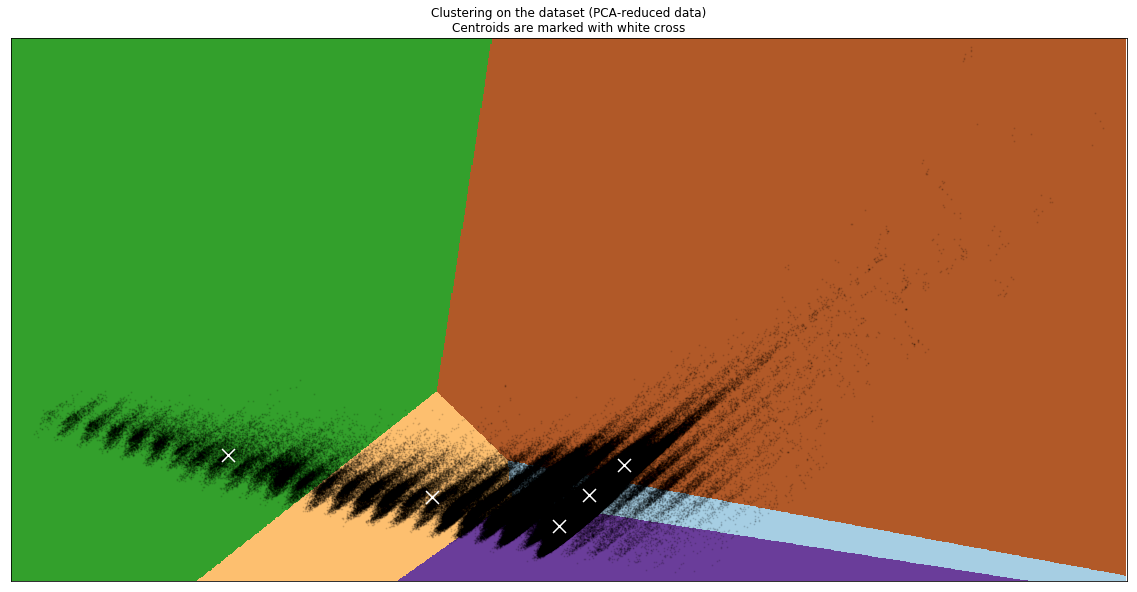

In [170]:
###  visualizes the clustering only using first 2 principal components

reduced_data = PCA(n_components=2).fit_transform(az4)
clusters = KMeans(n_clusters=5, random_state=100).fit(reduced_data)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))


Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

def PCA_plot(Z, centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(20, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2, alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

PCA_plot(Z, centroids)

# Memo

#### Custer 3's description above is for these features  
  
LP_STATUS_FEIN_10.0    2.017466   
LP_STATUS_GROB_5.0     2.017466   
GREEN_AVANTGARDE       1.823311   
FINANZ_MINIMALIST      1.030937   
KBA05_ANTG1            0.942899   
  

LP_STATUS_GROB_1.0   -0.767838   
FINANZ_HAUSBAUER     -0.774796   
house_wealth         -0.850519   
HH_EINKOMMEN_SCORE   -1.327282      
mainstream           -1.813994      
   
#### Custer 1's description above is for these features   
     
LP_STATUS_FEIN_2.0    1.180701            
FINANZ_SPARER         1.148216         
FINANZTYP_1           1.075831      
LP_STATUS_GROB_1.0    1.030095   
interval_type         0.895851   
dtype: float64 

KBA05_ANTG1            -0.753492   
MOBI_REGIO             -0.814399      
ALTERSKATEGORIE_GROB   -0.930268   
FINANZ_VORSORGER       -0.936601   
FINANZ_MINIMALIST      -1.192025      
   
#### Custer 4's description above is for these features 
  
FINANZ_UNAUFFAELLIGER    0.975956   
interval_type            0.925808   
FINANZ_ANLEGER           0.867952   
FINANZ_SPARER            0.829758   
LP_STATUS_FEIN_5.0       0.825935   
    
  
RETOURTYP_BK_S         -0.621471      
PLZ8_ANTG3             -0.624137   
ZABEOTYP_3             -0.684744   
ALTERSKATEGORIE_GROB   -0.850110   
FINANZ_VORSORGER       -0.885005   